# 0. Understanding the problem, the requirements and the goal

Predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation is a 30m x 30m patch. You are asked to predict an integer classification for the forest cover type. The seven types are:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

# 1. Data collection

We import all libraries and packages we will be using for this ML process

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, Normalizer, MinMaxScaler
#from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import cross_val_score, GridSearchCV, ParameterGrid, train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import linear_model
import seaborn as sns
from sklearn.svm import SVC
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import warnings
from scipy.stats.mstats import winsorize
import time

We set certain type of view, for improving visualizations of piplines and graphs, also set off warnings

In [2]:
warnings.filterwarnings('ignore') # Do not print warning messages

In [3]:
sklearn.set_config(display='diagram')
sns.set_style('whitegrid')

read the csv for the training and for the final test, df_test will not be part of the modeling, it will only serve for predicting and uploading to kaggle

In [4]:
df_train = pd.read_csv('train.csv').set_index('Id')
df_test = pd.read_csv('test.csv').set_index('Id')

Of the Training dataset, we will define X and y for the model and then we will split it into training and test dataset, with a 30%-70% split. Note: We started with a 20%-80% split but results on the test wasn´t that stable, each time we run the model the result changed abruptly, and since we are trying to predict a huge amount of data with a small sample... we reduce the amount of training data with the goal of creating a more stable regularized and generic model that is able to predict huge amount of data.

In [5]:
X = df_train.drop(columns='Cover_Type')
y = df_train['Cover_Type']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
X_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,
9419,3313,194,9,376,52,3360,219,247,163,1329,...,0,1,0,0,0,0,0,0,0,0
14872,2491,9,6,30,3,1254,214,228,152,1398,...,0,0,0,0,0,0,0,0,0,0
3453,2880,170,19,120,25,366,230,244,137,1032,...,0,0,0,0,0,0,0,0,0,0
2138,2832,41,17,85,12,1170,219,200,110,2295,...,0,0,0,0,0,0,0,0,0,0
12287,2074,80,12,30,4,966,236,218,111,247,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_train.shape

(10584, 54)

## 3. Data cleaning

We started by analyzing null data, to see if we needed to impute certain missing values. That was not necesary since there are no null values in this dataset.

In [9]:
X_train.isnull().sum().sum()

0

We needed to be sure that all features where integers before starting, so we print data types to make sure of it.

In [10]:
X_train.dtypes

Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                            int64
Soil_Type9                      

There are no nulls and the types are in the correct format.

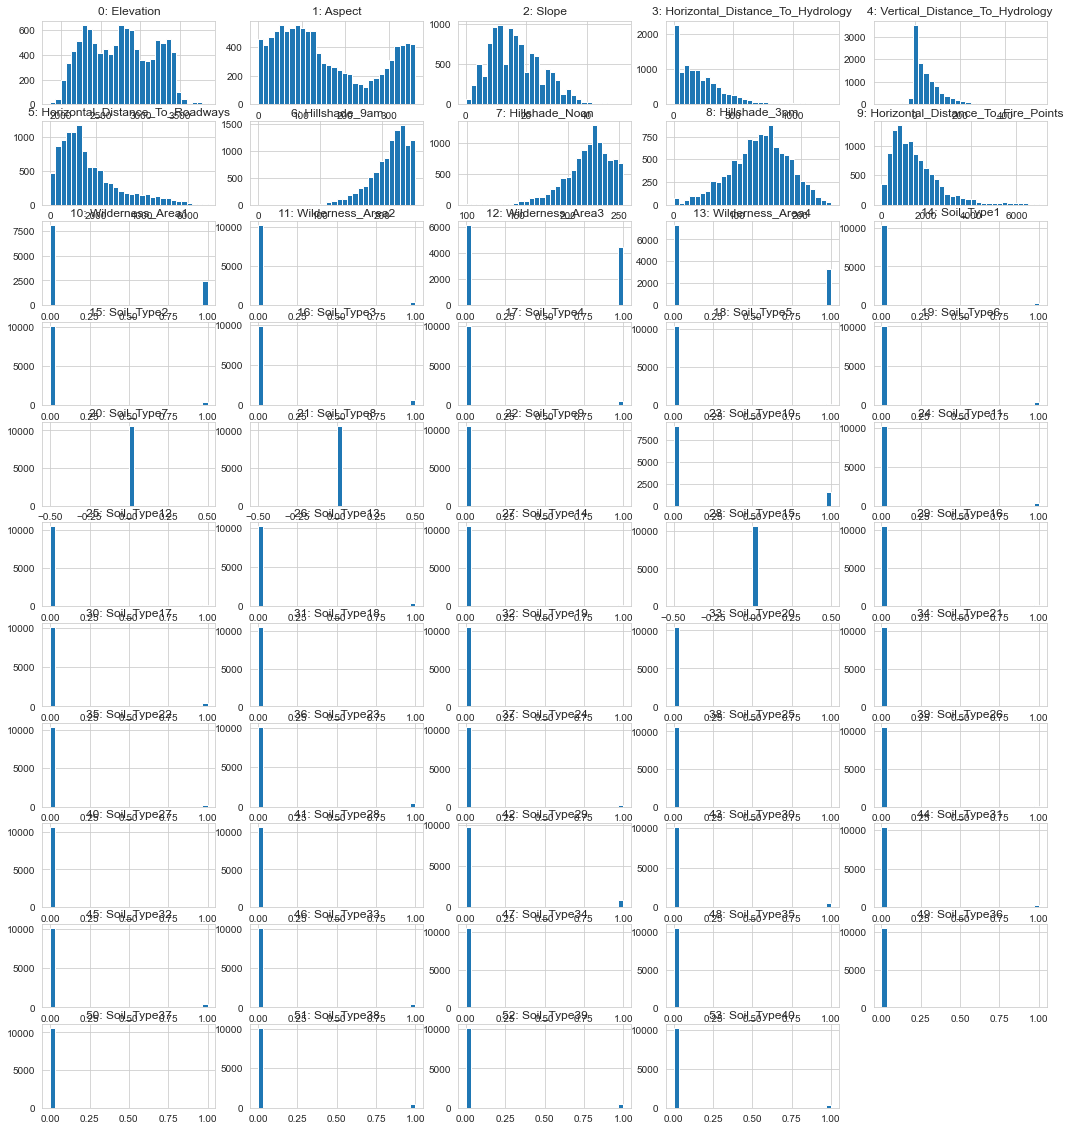

In [11]:
fig, axes = plt.subplots(11, 5, figsize=(18, 20))
for i, ax in enumerate(axes.ravel()):
    if i > 53:
        ax.set_visible(False)
        continue
    ax.hist(X_train.iloc[:, i], bins=30)
    ax.set_title("{}: {}".format(i, X_train.columns[i]))

We started with a overall visual look of the features.

Some variables are skewed to the left and others to the right. And some variables only have the one value.

Nevertheless, if a Random Forest is going to be applied, no transformation whatsoever is needed, since Decision Trees are not scale sensitive.

Furthermore, considering the size of the train set compared to the final test set, it would be risky to apply transformations to the data since we don't know the real distributions.

For modeling it is important to have uncorrelated features, so we run the correlation matrix to visualize it.

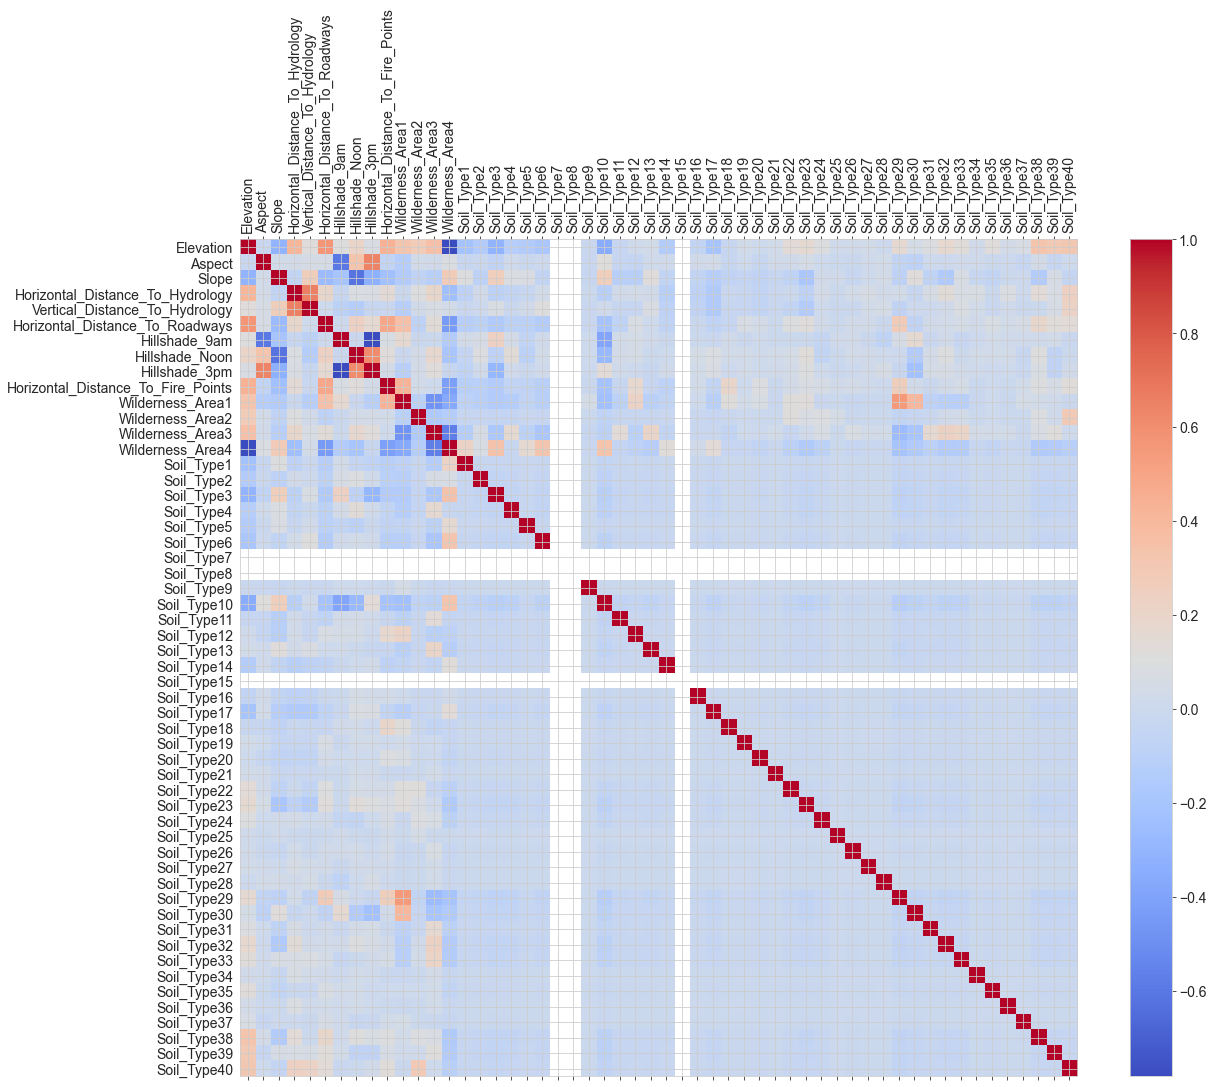

In [12]:
f = plt.figure(figsize=(19, 15))
plt.matshow(X_train.corr(), fignum=f.number, cmap=plt.cm.coolwarm)
plt.xticks(range(X_train.shape[1]), X_train.columns, fontsize=14, rotation=90)
plt.yticks(range(X_train.shape[1]), X_train.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [13]:
X_train.corr()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Elevation,1.000000,-0.016441,-0.307885,0.411872,0.118031,0.574611,0.104026,0.210168,0.080403,0.441522,...,0.092879,0.172386,0.128507,0.023210,0.122078,0.041393,0.067257,0.327117,0.295673,0.306223
Aspect,-0.016441,1.000000,0.027064,0.041364,0.057928,0.058888,-0.596807,0.326124,0.638263,-0.058834,...,0.005844,0.002607,0.015450,0.011831,-0.007868,0.003789,-0.041607,0.039809,-0.039834,0.007642
Slope,-0.307885,0.027064,1.000000,-0.054379,0.265277,-0.266222,-0.201697,-0.616267,-0.325409,-0.226939,...,-0.076989,-0.151380,0.067178,-0.032588,-0.054578,-0.005940,-0.002106,-0.145329,0.055993,-0.046624
Horizontal_Distance_To_Hydrology,0.411872,0.041364,-0.054379,1.000000,0.652099,0.194171,-0.028596,0.083789,0.077705,0.149674,...,0.053791,0.136137,0.064873,0.069782,-0.010798,0.081672,0.002533,0.137097,0.061504,0.238023
Vertical_Distance_To_Hydrology,0.118031,0.057928,0.265277,0.652099,1.000000,0.005175,-0.091685,-0.128345,-0.036635,-0.020262,...,-0.001539,0.022567,0.081962,0.033154,-0.019540,0.015797,-0.013611,-0.006978,0.057199,0.223974
Horizontal_Distance_To_Roadways,0.574611,0.058888,-0.266222,0.194171,0.005175,1.000000,-0.000527,0.238503,0.167898,0.486982,...,0.024869,0.032712,0.047020,0.022982,0.068216,0.031668,0.057072,0.197179,0.125613,0.142276
Hillshade_9am,0.104026,-0.596807,-0.201697,-0.028596,-0.091685,-0.000527,1.000000,-0.016840,-0.781201,0.071043,...,-0.017923,0.021106,-0.041116,0.004028,0.032708,0.012716,0.011696,0.013756,0.036368,-0.017027
Hillshade_Noon,0.210168,0.326124,-0.616267,0.083789,-0.128345,0.238503,-0.016840,1.000000,0.615658,0.116194,...,0.045719,0.099542,-0.008893,0.032900,0.034252,0.030544,-0.028345,0.104515,-0.066612,-0.008288
Hillshade_3pm,0.080403,0.638263,-0.325409,0.077705,-0.036635,0.167898,-0.781201,0.615658,1.000000,0.043455,...,0.053016,0.058378,0.019973,0.018187,0.000436,0.006154,-0.022308,0.067497,-0.070914,0.019624
Horizontal_Distance_To_Fire_Points,0.441522,-0.058834,-0.226939,0.149674,-0.020262,0.486982,0.071043,0.116194,0.043455,1.000000,...,-0.014553,0.020812,0.048347,-0.009328,0.005283,-0.009184,0.026331,0.095280,0.053391,0.125021


It seems we have some variables that are correlated. Later on we are going to apply PCA just to the non-binary variables to check if we can improve the model reducing the dimensions.

Another important thing to check is the distribution of the sample:

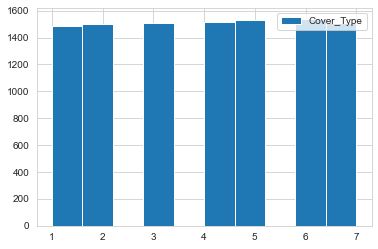

In [14]:
y_train.hist(label='Cover_Type')
plt.legend()

The Cover Type is equally distributed in our training set so we will not need to weight the classes later.

# 4. Feature engineering

We started this process by evaluating different processes for dealing with outliers, we decided to use the winsor function. This function use a floor and a cap for values outside a predefine tail cut.

We used a cut off tail of .01, since while running different tryouts we come to the conclusion that outliers where helping the model accuracy, so we left a "small" cut off and try the models with and without winsor function in the gridsearch.

In [15]:
def winsor_01(serie):
    return winsorize(serie, limits=[0.01, 0.01])
winsor01 = FunctionTransformer(winsor_01)

We decided to use Random Forest as primary model, since we intuitively thought that this would be the best model for this classification problem. RF is a good model for nonlinear solutions, it works well when you have different types of variables such as categorical and numerical and it  has good internal algorithms to avoid overfitting such as boosting, boat trap aggregation.

Still we run a grid search with a Support Vector Classifier, to see if the model could be improved with another type of model.

In [16]:
rf = RandomForestClassifier(n_jobs=-1)
svc = SVC()

In [17]:
rf.fit(X_train,y_train)
cross_val_score(rf,X_train,y_train).mean()

0.8494896387422728

In [18]:
rf.score(X_test, y_test)

0.8489858906525574

This is the first score for our test set. This is going to be our benchmark and we are going to try to improve it.



As next steps, to see if we can improve the baseline score. We run a feature_importance function, to see which variables are the most relevant in the model.

In [19]:
feature_importance = rf.feature_importances_
feature_importance_norm = pd.Series(np.std([tree.feature_importances_ for tree in rf.estimators_], axis = 0))\
.set_axis(X.columns).sort_values(ascending=False)

Text(0.5, 1.0, '"Mean decrease in impurity"')

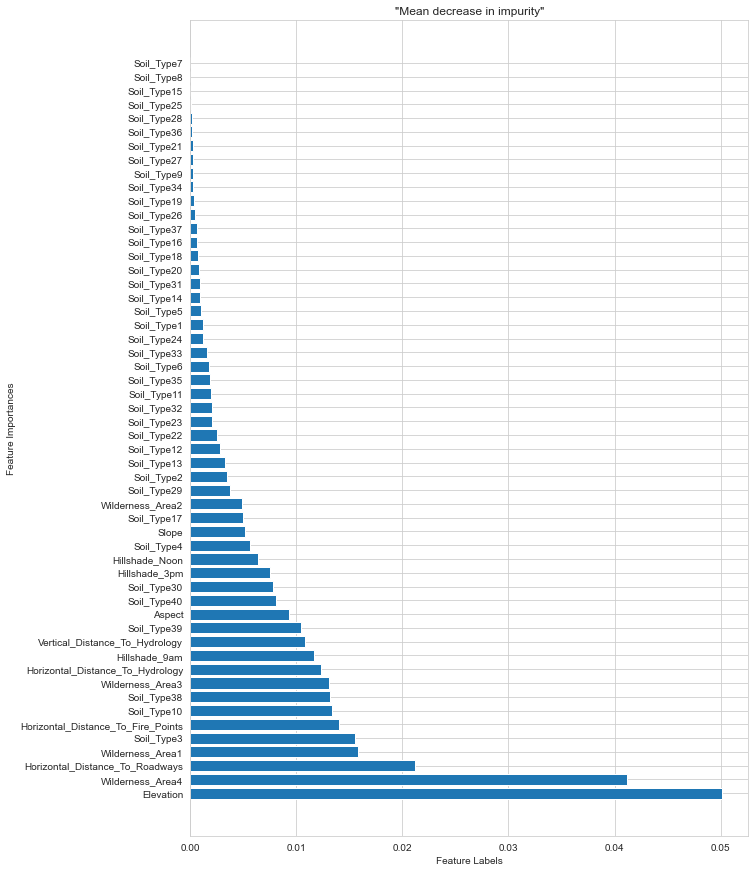

In [20]:
fig, axes = plt.subplots(figsize=(10,15))
plt.barh(feature_importance_norm.index,feature_importance_norm)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('"Mean decrease in impurity"')

This is a first view of the most important variables in our model. This might change after applying changes.

Now we are going to build a pipeline to start applying changes to our model.

We start by calling different type of scalers for the non_binaray variables as the PCA that we are gona use also on them.

In [21]:
norm = Normalizer()
robust = RobustScaler()

In [22]:
pca = PCA()

We generate a pipeline only for the nonbinary variables, since they will have different treatment: already scaled and no PCA applyied

In [23]:
ct_nonbinary = Pipeline([
    ('scaler', norm),
    ('outliers', winsor01),
    ('pca', pca)
])
ct_nonbinary

Pipeline(steps=[('scaler', Normalizer()),
                ('outliers',
                 FunctionTransformer(func=<function winsor_01 at 0x000002799840D0D0>)),
                ('pca', PCA())])

we generate a column transformer using the previos pipeline only for the non_binary variables, and the binary we only apply a passthrough.

In [24]:
ct = ColumnTransformer([
    ('non_binary', ct_nonbinary, slice(0,11)),
    ('passthrough', 'passthrough', slice(11,100))
])
ct

ColumnTransformer(transformers=[('non_binary',
                                 Pipeline(steps=[('scaler', Normalizer()),
                                                 ('outliers',
                                                  FunctionTransformer(func=<function winsor_01 at 0x000002799840D0D0>)),
                                                 ('pca', PCA())]),
                                 slice(0, 11, None)),
                                ('passthrough', 'passthrough',
                                 slice(11, 100, None))])

for feature selection, we used the function SelectKBest with an initial k= 20, we will try different K values in the gridsearch.

In [26]:
skb = SelectKBest(f_classif, k=20)

we generarte the final pipeline with the transformer, feature selection and the model we are going to use. This will give us our benchmark score.

In [27]:
pipeline = Pipeline([
    ('transformer', ct),
    ('feature_selection', skb),
    ('model', rf)
])
pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('non_binary',
                                                  Pipeline(steps=[('scaler',
                                                                   Normalizer()),
                                                                  ('outliers',
                                                                   FunctionTransformer(func=<function winsor_01 at 0x000002799840D0D0>)),
                                                                  ('pca',
                                                                   PCA())]),
                                                  slice(0, 11, None)),
                                                 ('passthrough', 'passthrough',
                                                  slice(11, 100, None))])),
                ('feature_selection', SelectKBest(k=20)),
                ('model', RandomForestClassifier(n_jobs=-1))])

In [28]:
cross_val_score(pipeline, X_train, y_train).mean()

0.7752245080556802

In [29]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('non_binary',
                                                  Pipeline(steps=[('scaler',
                                                                   Normalizer()),
                                                                  ('outliers',
                                                                   FunctionTransformer(func=<function winsor_01 at 0x000002799840D0D0>)),
                                                                  ('pca',
                                                                   PCA())]),
                                                  slice(0, 11, None)),
                                                 ('passthrough', 'passthrough',
                                                  slice(11, 100, None))])),
                ('feature_selection', SelectKBest(k=20)),
                ('model', RandomForestClassifier(n_jobs=-1))])

In [30]:
pipeline.score(X_test, y_test)

0.812389770723104

This is the baseline score for the pipeline. We are going to change hyperparameters to upgrade this score, and comparing it to the score we had applying a Random Forest with the default hyperparameters and no pipeline.

# 5. Model training

for modeling we started by defining different ranges for the pipeline inputs, that by running some previous test, we thought they could improved the model score.

In [31]:
n_components = range(4,9)
scalers = [norm, robust]
rf_depth = range(30,35)
n_features = range(39,45)
outliers = [winsor01, 'passthrough']

In [33]:
param_grid = [
    {'model': [rf], 'model__max_depth': rf_depth, 
             'transformer__non_binary__scaler': scalers, 
             'feature_selection__k': n_features, 
             'transformer__non_binary__pca__n_components': n_components,
             'transformer__non_binary__outliers': outliers},
]

In [35]:
num_par = len(list(ParameterGrid(param_grid)))
num_par

600

In [36]:
et = (num_par / 30)/60
F'Estimated time: {et} hours or {et*60} minutes for Random Forest'

'Estimated time: 0.3333333333333333 hours or 20.0 minutes for Random Forest'

In [37]:
%%time
gs = GridSearchCV(
    pipeline,
    param_grid = param_grid,
    cv = 5,
    n_jobs=-1
)
gs.fit(X_train, y_train)

Wall time: 20min 38s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('non_binary',
                                                                         Pipeline(steps=[('scaler',
                                                                                          Normalizer()),
                                                                                         ('outliers',
                                                                                          FunctionTransformer(func=<function winsor_01 at 0x000002799840D0D0>)),
                                                                                         ('pca',
                                                                                          PCA())]),
                                                                         slice(0, 11, None)),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         slice(11, 100, None))])),
                                       ('feature_selection', SelectKBest(k=20)),...
             param_grid=[{'feature_selection__k': range(39, 45),
                          'model': [RandomForestClassifier(max_depth=33,
                                                           n_jobs=-1)],
                          'model__max_depth': range(30, 35),
                          'transformer__non_binary__outliers': [FunctionTransformer(func=<function winsor_01 at 0x000002799840D0D0>),
                                                                'passthrough'],
                          'transformer__non_binary__pca__n_components': range(4, 9),
                          'transformer__non_binary__scaler': [Normalizer(),
                                                              RobustScaler()]}])

We run the best_params_ function get you the best model run by the gridsearch

In [38]:
best_params = gs.best_params_
best_params

{'feature_selection__k': 39,
 'model': RandomForestClassifier(max_depth=33, n_jobs=-1),
 'model__max_depth': 33,
 'transformer__non_binary__outliers': 'passthrough',
 'transformer__non_binary__pca__n_components': 7,
 'transformer__non_binary__scaler': Normalizer()}

In [39]:
gs.best_score_

0.8367345362458736

In [40]:
gs_results = pd.DataFrame(gs.cv_results_)

In [41]:
gs_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selection__k,param_model,param_model__max_depth,param_transformer__non_binary__outliers,param_transformer__non_binary__pca__n_components,param_transformer__non_binary__scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.574328,0.074227,0.052020,0.006543,39,"(DecisionTreeClassifier(max_features='auto', r...",30,FunctionTransformer(func=<function winsor_01 a...,4,Normalizer(),"{'feature_selection__k': 39, 'model': (Decisio...",0.805857,0.802078,0.802551,0.799244,0.798204,0.801587,0.002696,308
1,0.752549,0.125854,0.056243,0.012499,39,"(DecisionTreeClassifier(max_features='auto', r...",30,FunctionTransformer(func=<function winsor_01 a...,4,RobustScaler(),"{'feature_selection__k': 39, 'model': (Decisio...",0.732641,0.748229,0.739254,0.739726,0.727316,0.737433,0.007077,565
2,0.522546,0.032227,0.059369,0.028640,39,"(DecisionTreeClassifier(max_features='auto', r...",30,FunctionTransformer(func=<function winsor_01 a...,5,Normalizer(),"{'feature_selection__k': 39, 'model': (Decisio...",0.826169,0.821445,0.819084,0.821445,0.818526,0.821334,0.002696,236
3,0.547557,0.026667,0.090615,0.033365,39,"(DecisionTreeClassifier(max_features='auto', r...",30,FunctionTransformer(func=<function winsor_01 a...,5,RobustScaler(),"{'feature_selection__k': 39, 'model': (Decisio...",0.782239,0.792159,0.786018,0.794521,0.767958,0.784579,0.009382,495
4,0.576872,0.026875,0.074170,0.025406,39,"(DecisionTreeClassifier(max_features='auto', r...",30,FunctionTransformer(func=<function winsor_01 a...,6,Normalizer(),"{'feature_selection__k': 39, 'model': (Decisio...",0.834199,0.818611,0.830420,0.824752,0.827032,0.827003,0.005272,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.790540,0.032170,0.087490,0.007653,44,"(DecisionTreeClassifier(max_features='auto', r...",34,passthrough,6,RobustScaler(),"{'feature_selection__k': 44, 'model': (Decisio...",0.795465,0.792159,0.790269,0.799244,0.777410,0.790910,0.007408,434
596,0.664263,0.042641,0.074992,0.028638,44,"(DecisionTreeClassifier(max_features='auto', r...",34,passthrough,7,Normalizer(),"{'feature_selection__k': 44, 'model': (Decisio...",0.839395,0.839395,0.837034,0.840812,0.827032,0.836734,0.005000,2
597,0.791826,0.040252,0.106239,0.028637,44,"(DecisionTreeClassifier(max_features='auto', r...",34,passthrough,7,RobustScaler(),"{'feature_selection__k': 44, 'model': (Decisio...",0.788852,0.803496,0.787907,0.802551,0.784026,0.793366,0.008054,372
598,0.769436,0.040582,0.096865,0.026880,44,"(DecisionTreeClassifier(max_features='auto', r...",34,passthrough,8,Normalizer(),"{'feature_selection__k': 44, 'model': (Decisio...",0.842230,0.835144,0.827586,0.834199,0.834121,0.834656,0.004649,12


# 6. Model evaluation

The model did improved, we got from a 0.8123897 score that we got for benchmark, to a .8441358 by changing some parameters with our final model 

In [43]:
gs.score(X_test, y_test)

0.8441358024691358

we change the pipeline with the parameters that we got of the gridsearch, parameters of our final model.

In [44]:
pipeline.set_params(**best_params)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('non_binary',
                                                  Pipeline(steps=[('scaler',
                                                                   Normalizer()),
                                                                  ('outliers',
                                                                   'passthrough'),
                                                                  ('pca',
                                                                   PCA(n_components=7))]),
                                                  slice(0, 11, None)),
                                                 ('passthrough', 'passthrough',
                                                  slice(11, 100, None))])),
                ('feature_selection', SelectKBest(k=39)),
                ('model', RandomForestClassifier(max_depth=33, n_jobs=-1))])

In [45]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('non_binary',
                                                  Pipeline(steps=[('scaler',
                                                                   Normalizer()),
                                                                  ('outliers',
                                                                   'passthrough'),
                                                                  ('pca',
                                                                   PCA(n_components=7))]),
                                                  slice(0, 11, None)),
                                                 ('passthrough', 'passthrough',
                                                  slice(11, 100, None))])),
                ('feature_selection', SelectKBest(k=39)),
                ('model', RandomForestClassifier(max_depth=33, n_jobs=-1))])

In [46]:
pipeline.score(X_test, y_test)

0.8425925925925926

And we run the prediction with the final pipelin

In [47]:
final_results = pd.DataFrame(pipeline.predict(df_test))
final_results

,0
0,2
1,1
2,1
3,1
4,1
...,...
565887,3
565888,3
565889,3
565890,3


In [48]:
final_results.to_csv('submission.csv', index=False)